# Marketing Mix Modeling (MMM) Analysis

In this analysis, we will examine the effectiveness of advertising campaigns using a Marketing Mix Modeling (MMM) approach. We will utilize sample data to apply transformations, optimize model parameters, and evaluate the model's performance. 

### Objectives:
- Load and preprocess the data
- Apply relevant transformations (e.g., adstock and saturation)
- Optimize the model parameters for best performance
- Evaluate the model's effectiveness and diagnose its performance

By the end of this analysis, we aim to gain insights into how different marketing channels contribute to sales performance 

In [1]:
# Importing necessary libraries
import pandas as pd
import yaml
import numpy as np
import matplotlib.pyplot as plt

import sys
import os

# Add the src directory to the system path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))

from data_transformer import DataTransformer
from model_optimizer import ModelOptimizer
from model_diagnostics import ModelDiagnostics
from helper.helper import perform_eda, handle_seasonality, visualize_marketing_channels_and_sales, check_multicollinearity

## Data & Config Loading

In [2]:
# Load the sample data file and YAML configuration
# Define file paths
data_file_path = '../data/sample_data.csv'  # Adjust if necessary
yaml_file_path = '../config/params_sample.yaml'

In [3]:
# Load the sample data
sample_data = pd.read_csv(data_file_path, index_col=0, parse_dates=True, dayfirst=True)
print("Data Loaded:")
sample_data.head()  # Display the first few rows of the data

Data Loaded:


,TV_Spend,Radio_Spend,Digital_Spend,Average_Promo,Seasonality,Sales
Week,,,,,,
2022-01-03,200.662,24.375,228.213987,0.133842,-1.49,5082
2022-01-10,218.428,15.913,34.258574,0.151338,-1.94,5133
2022-01-17,121.939,12.887,127.691261,0.120310,0.07,5178
2022-01-24,111.207,0.000,84.014720,0.103425,-1.46,5150
2022-01-31,218.158,0.000,20.687478,0.104563,1.23,5238


In [4]:
sample_data.tail()

,TV_Spend,Radio_Spend,Digital_Spend,Average_Promo,Seasonality,Sales
Week,,,,,,
2023-11-27,157.072,0.000,125.711222,0.419900,0.29,5124
2023-12-04,143.629,0.000,141.956391,0.341851,-1.07,5140
2023-12-11,123.503,0.000,158.201560,0.452185,1.61,5195
2023-12-18,241.308,10.322,106.584449,0.205402,0.98,5245
2023-12-25,138.485,11.240,228.003055,0.223283,0.87,5260


In [5]:
# Load parameters from the YAML file
with open(yaml_file_path, 'r') as file:
    config = yaml.safe_load(file)

In [6]:
# Check for target column
target_column = config['target']
if target_column in sample_data.columns:
    print(f"Target column '{target_column}' is present in the DataFrame.")
else:
    print(f"Target column '{target_column}' is NOT present in the DataFrame.")

# Check for active channels
active_channels = [channel['name'] for channel in config['channels'] if channel['is_active']]
missing_channels = [channel for channel in active_channels if channel not in sample_data.columns]

if not missing_channels:
    print("All active channels are present in the DataFrame.")
else:
    print(f"Missing active channels: {', '.join(missing_channels)}")

# Check for active additional columns
active_additional_columns = [col['name'] for col in config['additional_columns'] if col['is_active']]
missing_additional_columns = [col for col in active_additional_columns if col not in sample_data.columns]

if not missing_additional_columns:
    print("All active additional columns are present in the DataFrame.")
else:
    print(f"Missing active additional columns: {', '.join(missing_additional_columns)}")

Target column 'Sales' is present in the DataFrame.
All active channels are present in the DataFrame.
All active additional columns are present in the DataFrame.


In [7]:
# Define target KPI variable
kpi = config['target']
marketingChannels = [chan['name'] for chan in config['channels']]
additionalChannels = [chan['name'] for chan in config['additional_columns']]

print(f'{"KPI:":20} {kpi}\n{"Marketing Channels:":20} {", ".join(marketingChannels)}\n{"Additional Channels:":20} {", ".join(additionalChannels)}')

KPI:                 Sales
Marketing Channels:  TV_Spend, Radio_Spend, Digital_Spend
Additional Channels: Average_Promo, Seasonality


## Exploratory Data Analysis

         TV_Spend  Radio_Spend  Digital_Spend  Average_Promo  Seasonality  \
count  104.000000   104.000000     104.000000     104.000000   104.000000   
mean   105.534462     6.525875      68.003367       0.163537     0.093173   
std     93.404653     8.705606      82.310487       0.094005     1.115036   
min      0.000000     0.000000       0.000000       0.039518    -2.000000   
25%      0.000000     0.000000       0.000000       0.100896    -0.752500   
50%    122.721000     0.000000      28.662070       0.133021     0.080000   
75%    194.422250    14.341750     126.206232       0.212824     0.937500   
max    247.875000    24.673000     417.018577       0.461621     1.980000   

            Sales  
count   104.00000  
mean   5157.75000  
std      81.93755  
min    4994.00000  
25%    5094.00000  
50%    5170.00000  
75%    5218.00000  
max    5332.00000  

Correlation plot:


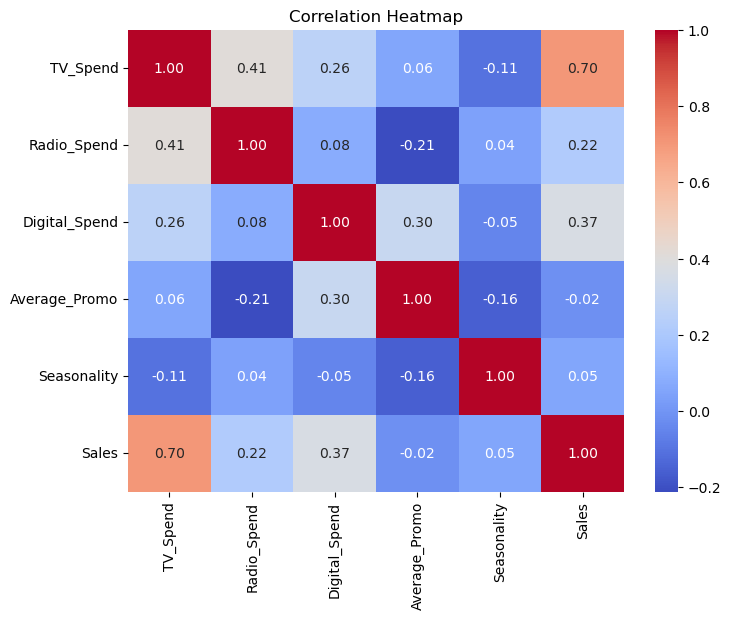

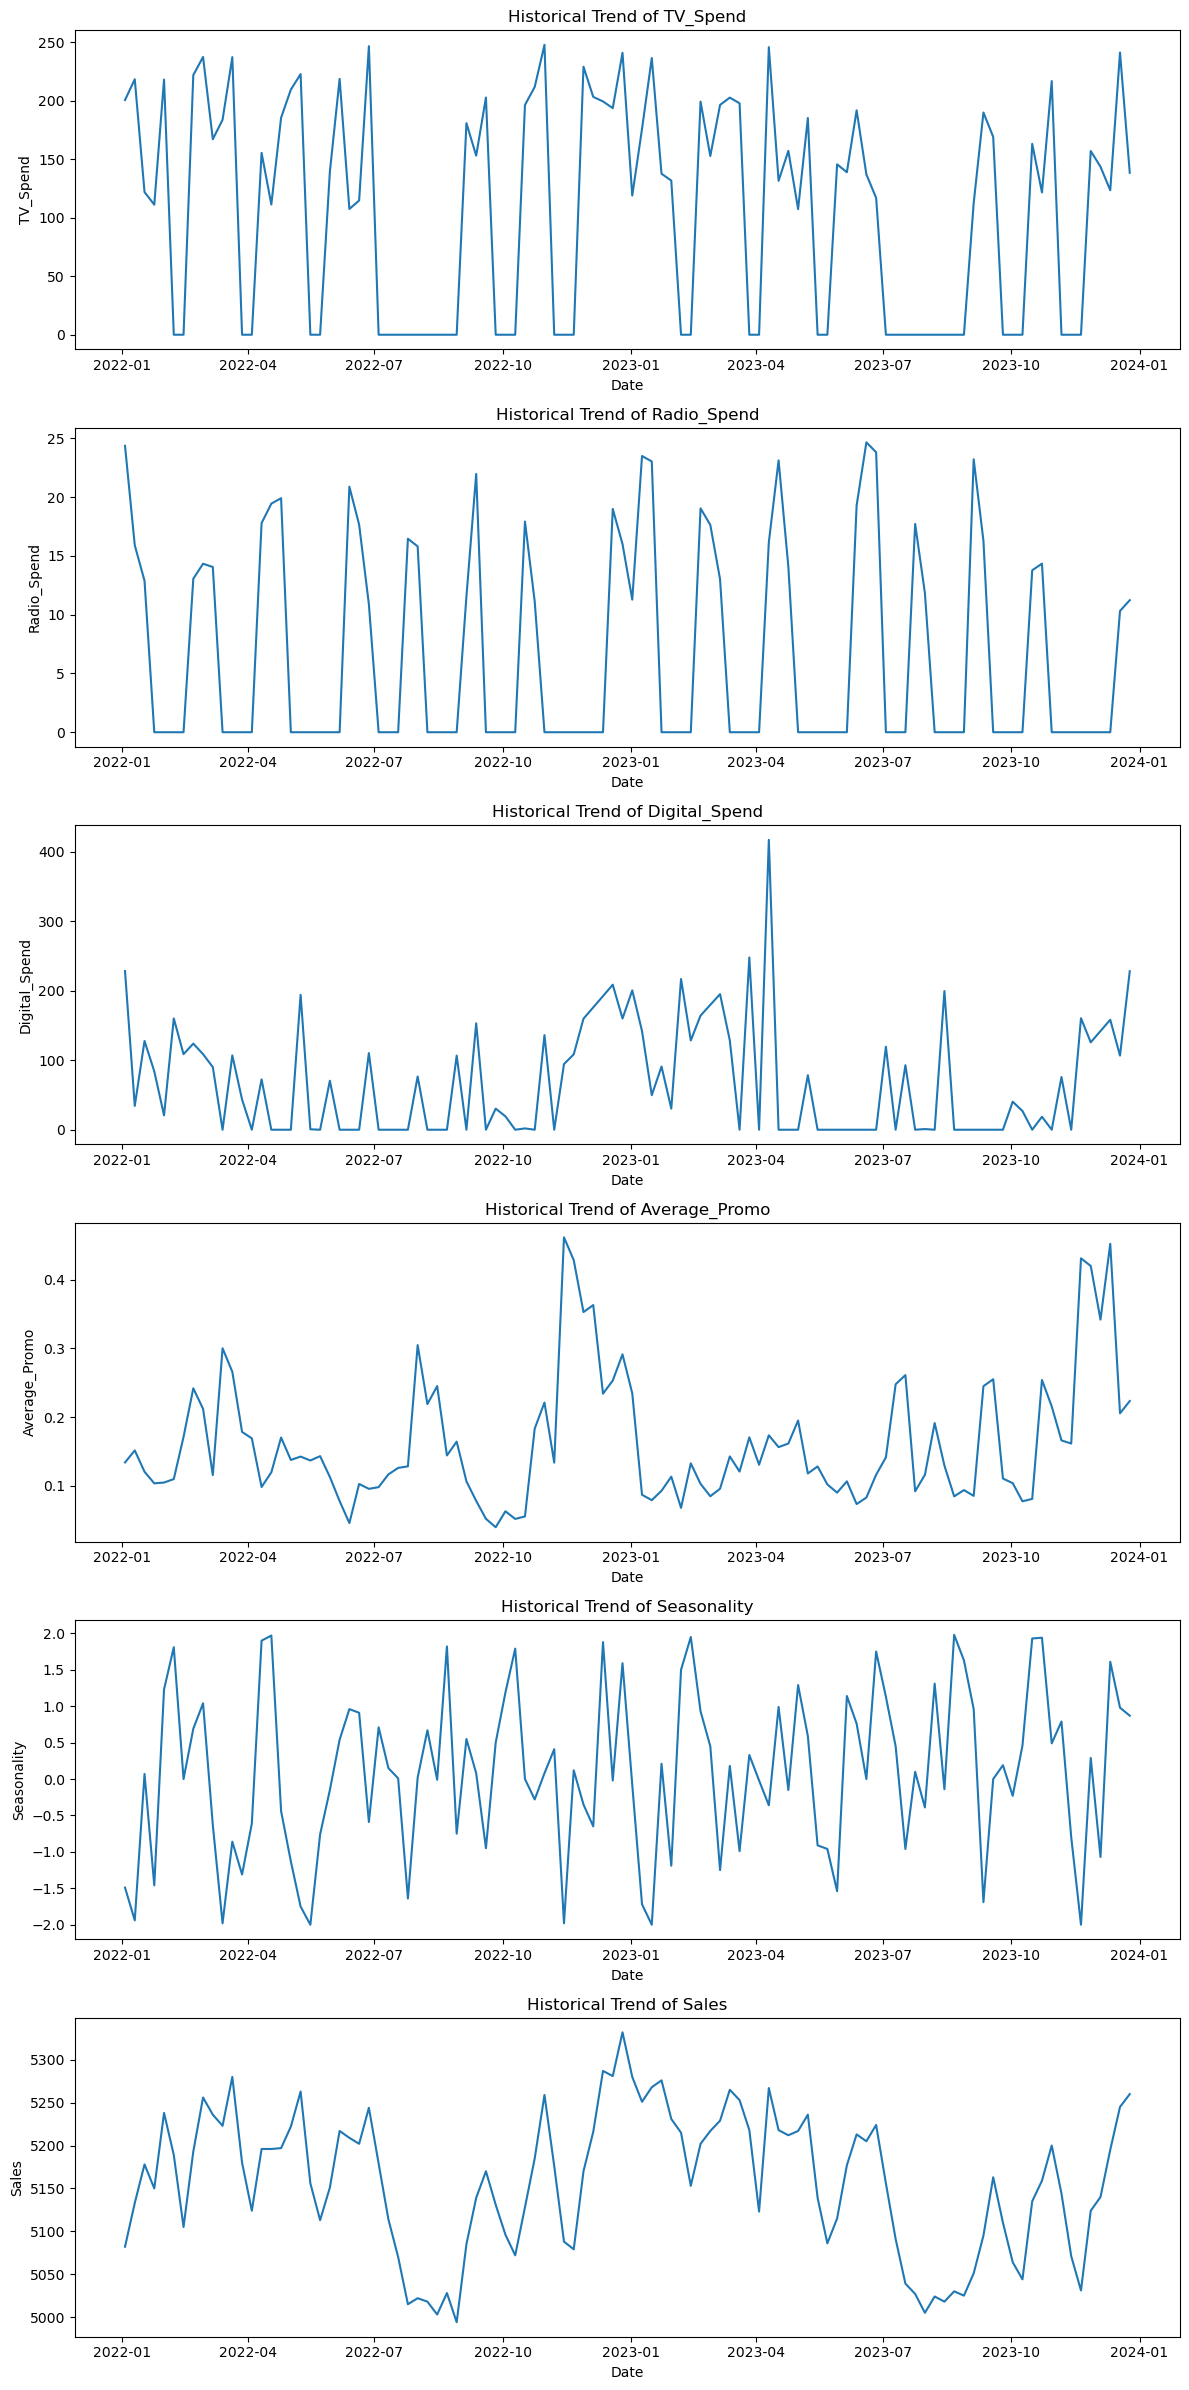

In [8]:
perform_eda(sample_data)

### Visualize Mkt Channels and Sales

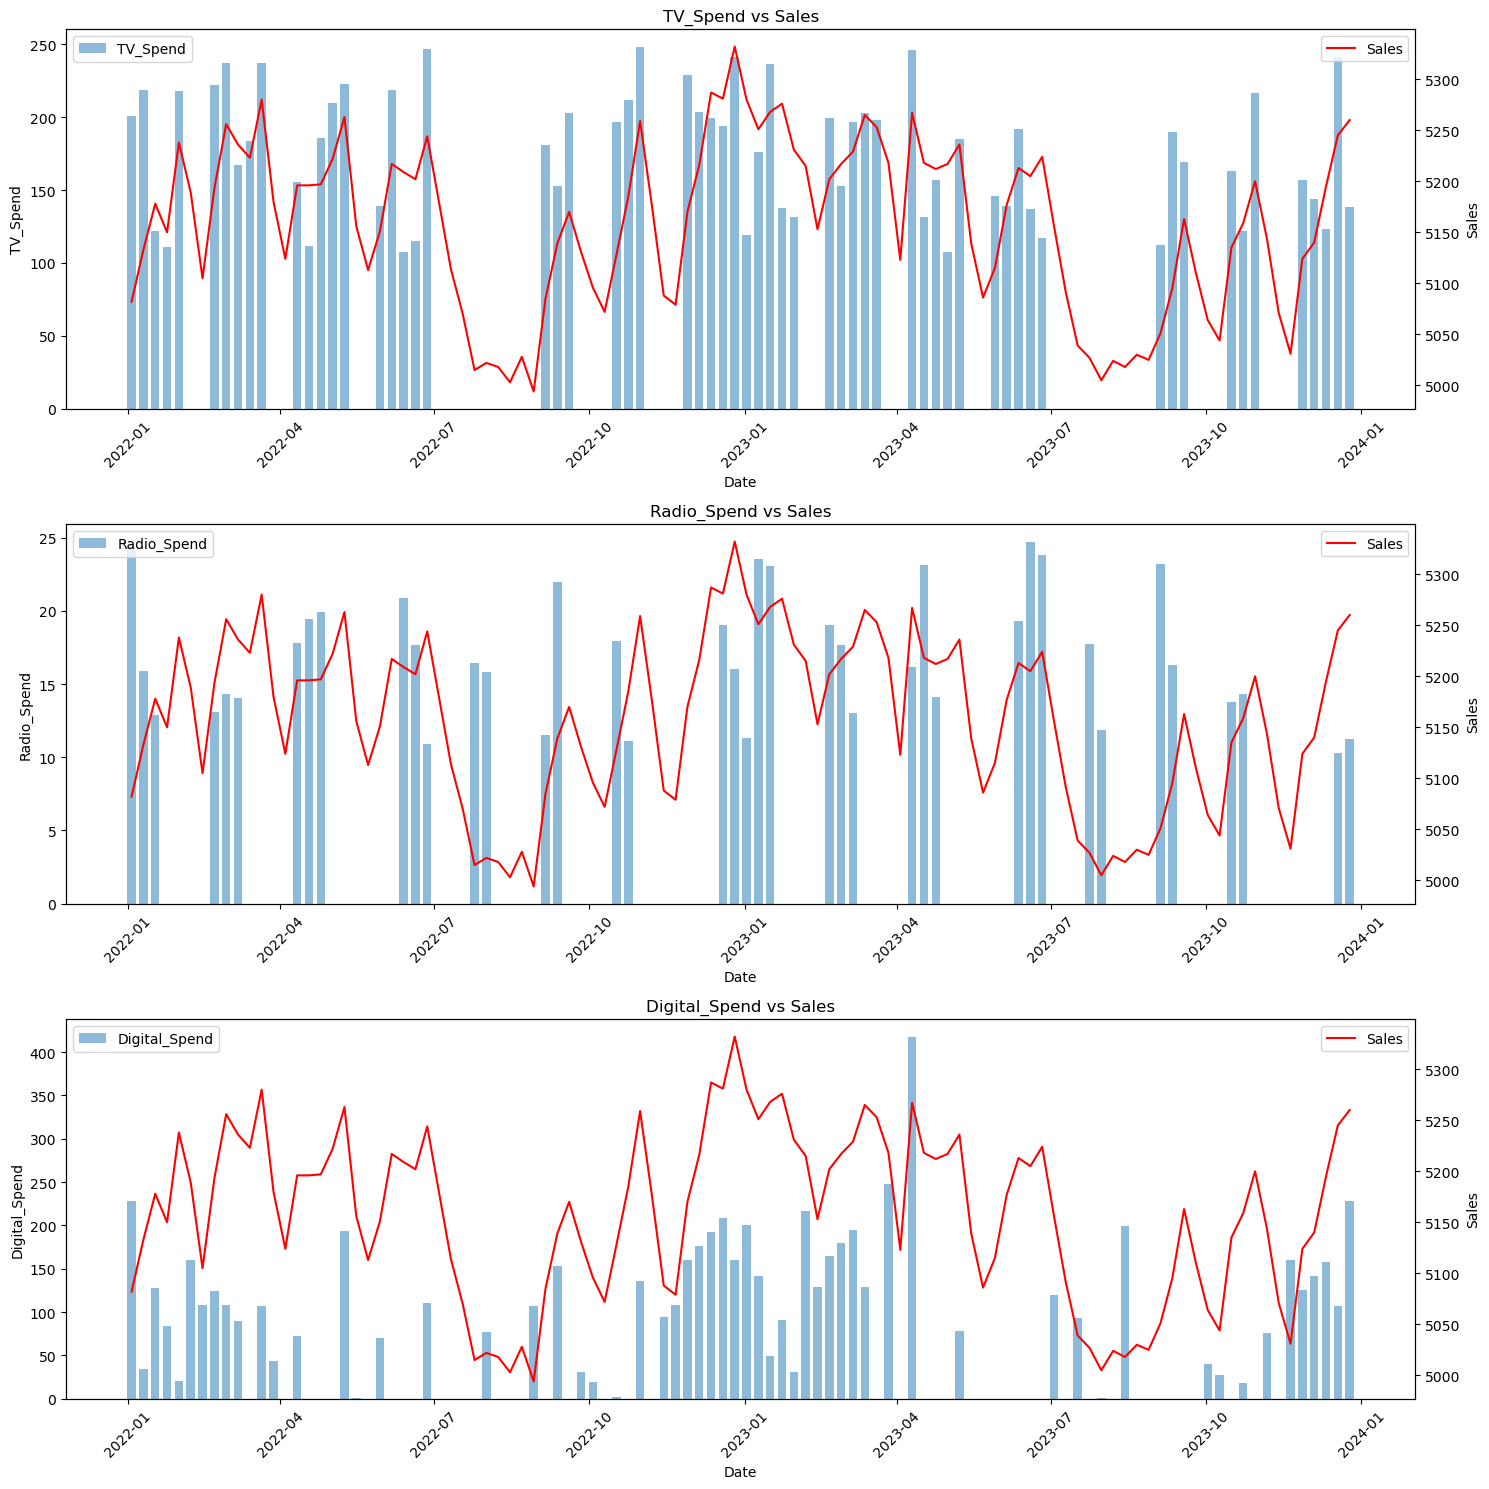

In [9]:
visualize_marketing_channels_and_sales(sample_data, kpi, marketingChannels)

### Checking for Multicollinearity

Multicollinearity refers to a situation where two or more predictor variables in a regression model are highly correlated. This can lead to issues in estimating coefficients reliably and interpreting their significance. 

The Variance Inflation Factor (VIF) is a common method to quantify multicollinearity. Generally, the following thresholds are used to evaluate VIF values:

- **VIF = 1**: No correlation between the variable and other variables.
- **1 < VIF < 5**: Moderate correlation, not problematic.
- **5 ≤ VIF < 10**: High correlation, indicating a potential problem.
- **VIF ≥ 10**: Very high correlation, suggesting that the variable may need to be removed from the model to improve its reliability.

In the following section, we will utilize the `check_multicollinearity` function to assess the multicollinearity of the features in our dataset and identify any variables that may be problematic.


In [10]:
check_multicollinearity(sample_data[marketingChannels + additionalChannels[:-1]])

,Feature,VIF
0,TV_Spend,2.778604
1,Radio_Spend,1.809939
2,Digital_Spend,1.992720
3,Average_Promo,2.254168


## Transform Data

### Handle Seasonality Component (ptional)

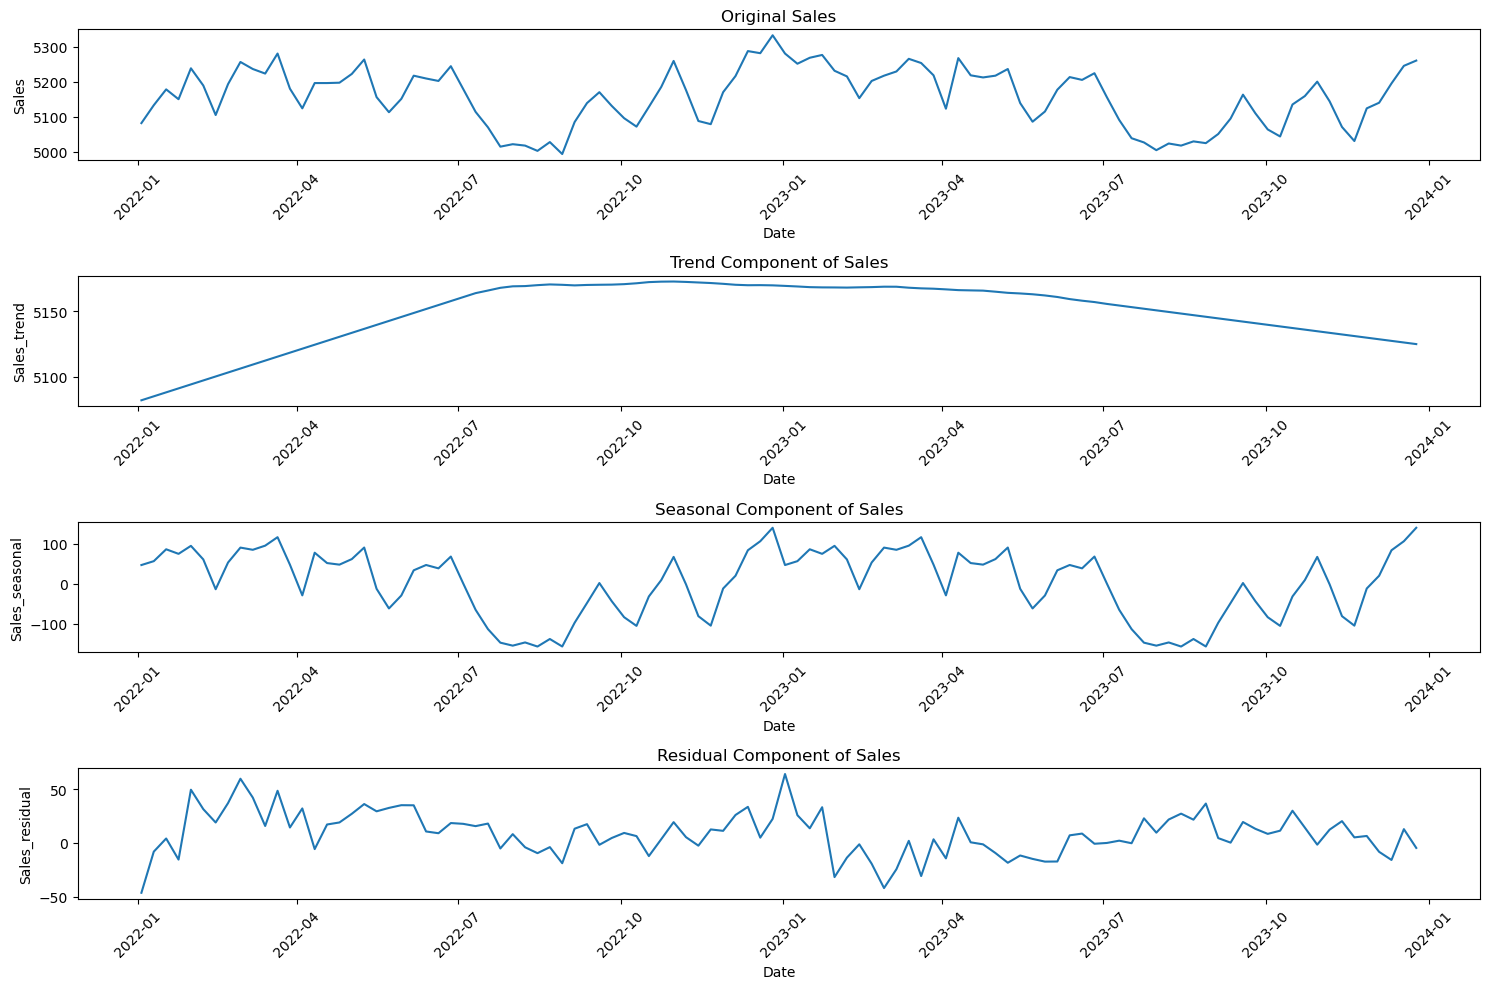

,TV_Spend,Radio_Spend,Digital_Spend,Average_Promo,Seasonality,Sales,Sales_trend,Sales_seasonal,Sales_residual
Week,,,,,,,,,
2022-01-03,200.662,24.375,228.213987,0.133842,-1.49,5082,5081.942308,46.501109,-46.443417
2022-01-10,218.428,15.913,34.258574,0.151338,-1.94,5133,5084.980769,56.203033,-8.183802
2022-01-17,121.939,12.887,127.691261,0.120310,0.07,5178,5088.019231,85.943417,4.037352
2022-01-24,111.207,0.000,84.014720,0.103425,-1.46,5150,5091.057692,74.515533,-15.573225
2022-01-31,218.158,0.000,20.687478,0.104563,1.23,5238,5094.096154,94.520340,49.383506
...,...,...,...,...,...,...,...,...,...
2023-11-27,157.072,0.000,125.711222,0.419900,0.29,5124,5129.884615,-12.263314,6.378698
2023-12-04,143.629,0.000,141.956391,0.341851,-1.07,5140,5128.653846,19.717456,-8.371302
2023-12-11,123.503,0.000,158.201560,0.452185,1.61,5195,5127.423077,83.505917,-15.928994


In [11]:
handle_seasonality(sample_data, kpi)

## Model Builder


In this section, we will build a regression model to analyze the impact of various factors on sales. This involves using the previously defined classes and functions to streamline our workflow.

1. **Data Transformation**: We'll preprocess the data using the `DataTransformer` class, which includes handling seasonality and performing exploratory data analysis (EDA).
2. **Model Fitting**: We'll fit a regression model using the `ModelOptimizer` class, which will help us select the best model parameters.
3. **Model Diagnostics**: Finally, we will evaluate the model's performance using the `ModelDiagnostics` class to ensure our model is reliable and valid.



### Building the Model

1. **Create ModelOptimizer Instance**  
   Create an instance of the `ModelOptimizer` class by providing the path to the YAML configuration file. 
   This configuration file typically contains parameters for the model, including bounds and active statuses that dictate how the model will behave during optimization.

2. **Access Model Parameters**  
   Access the parameters set in the model using the `value` attribute. 
   This attribute retrieves the current values of the model parameters as specified in the configuration. Understanding these values is crucial 
   for analyzing the model's settings and ensuring they align with the intended design.

3. **Optimize Model Parameters**  
   Invoke the `optimize_parameters` method of the `ModelOptimizer` class. This method is designed to optimize 
   the model parameters based on the provided sample data. It utilizes specific algorithms defined within 
   the `ModelOptimizer` to identify the best-fitting parameters, which can significantly enhance the model's performance and accuracy.


In [12]:
# Create an instance of the ModelOptimizer class by providing the path to the YAML configuration file.
model = ModelOptimizer(config_path=yaml_file_path, budget=500)

# Call the optimize_parameters method of the ModelOptimizer class.
model.optimize_parameters(sample_data)


Selected Target           Sales
Media Channels            ['TV_Spend', 'Radio_Spend', 'Digital_Spend']
Additional Information    ['Average_Promo', 'Seasonality']

Optimization Succeded


In [13]:
# Print Model Coefficients
print("Model Coefficients:")
for channel, coefficient in model.coefficients_dict.items():
    print(f"{channel:20}: {coefficient:.4f}")

Model Coefficients:
Baseline            : 5010.3155
TV_Spend            : 0.4700
Radio_Spend         : 0.4200
Digital_Spend       : 0.2800
Average_Promo       : 0.4800
Seasonality         : 14.4776


#### Diagnostic Metrics

In [15]:
# Get diagnostics
diagnostics = model.get_diagnostics()

# Calculate and display metrics
print('Model Main Metrics')
metrics = diagnostics.calculate_metrics()
for metric, result in metrics.items():
    print(f"{metric:20}: {result:.4f}")

Model Main Metrics
R²                  : 0.9966
Adjusted R²         : 0.9963
RMSE                : 4.7835
Durbin-Watson       : 0.1490
MAPE                : 0.0008


#### Regression Summary

In [16]:
# Display regression summary
summary = diagnostics.calculate_regression_summary()
summary

,Coefficient Name,Coefficient Value,Standard Error,P-Value,Lower 95% CL,Upper 95% CL
0,Baseline,5010.315538,1.373538,0.000000,5007.623404,5013.007671
1,TV_Spend,0.470000,0.003214,0.000000,0.463701,0.476299
2,Radio_Spend,0.420000,1.243883,0.736347,-2.018012,2.858012
3,Digital_Spend,0.280000,0.014614,0.000000,0.251357,0.308643
4,Average_Promo,0.480000,5.448800,0.929983,-10.199648,11.159648
5,Seasonality,14.477603,0.446721,0.000000,13.602031,15.353175


### Plot Results

[9.71414965e-01 2.71817768e-02 1.54593170e-05 1.11104203e-03
 1.52193964e-05 2.61533190e-04] ['Baseline', 'TV_Spend', 'Radio_Spend', 'Digital_Spend', 'Average_Promo', 'Seasonality']


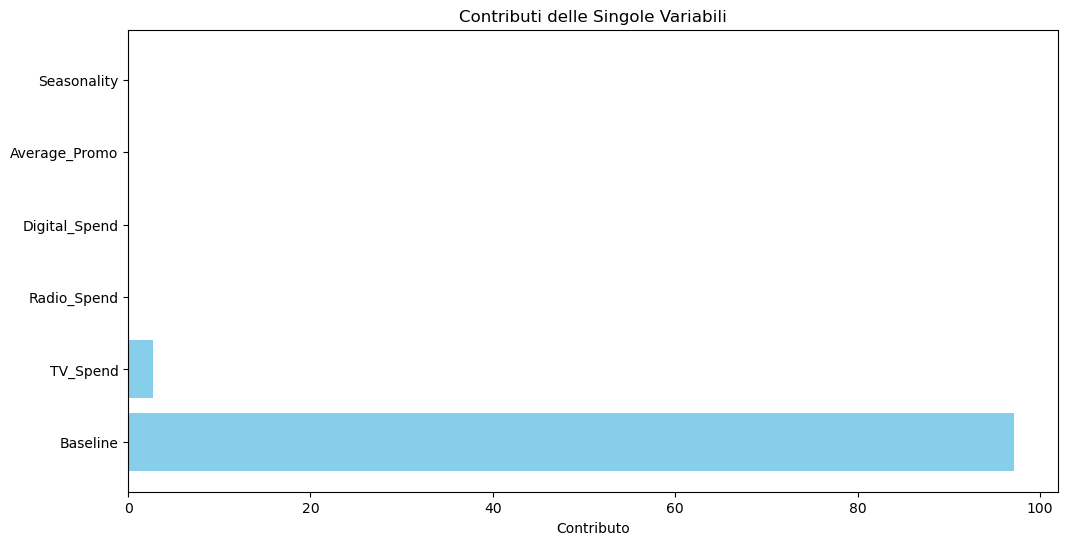

In [17]:
model.plot_variable_contributions()

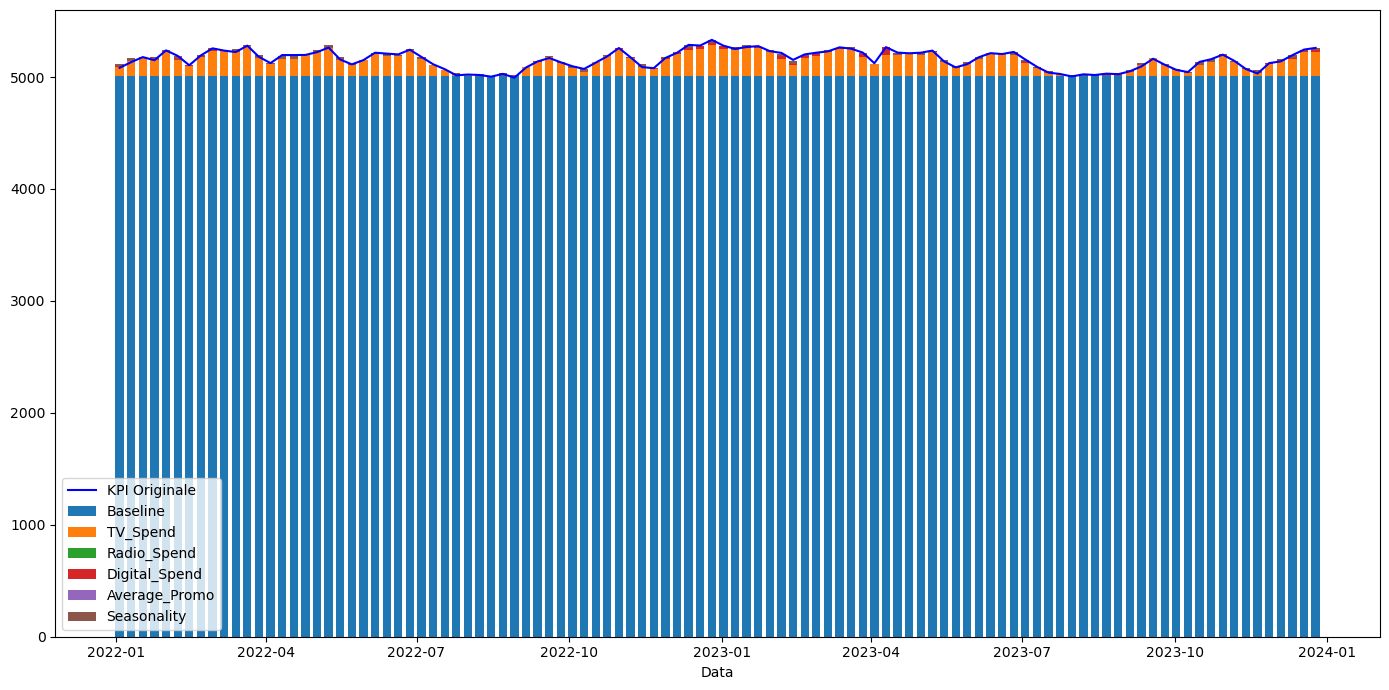

In [18]:
model.plot_historical_kpi_with_contributions()

In [19]:
model.params.value

{'TV_Spend_decay': 0.6991785045652723,
 'TV_Spend_saturation_type': 'hill',
 'TV_Spend_k': 2.408687092860101,
 'TV_Spend_x0': 100.20025187433622,
 'Radio_Spend_decay': 0.5637880211252146,
 'Radio_Spend_saturation_type': 'hill',
 'Radio_Spend_k': 3.2145698684162967,
 'Radio_Spend_x0': 77.86523248392858,
 'Digital_Spend_decay': 0.07960853393642967,
 'Digital_Spend_saturation_type': 'hill',
 'Digital_Spend_k': 1.402280252027933,
 'Digital_Spend_x0': 313.4416475739973}

#### Saturation Curves

Saturation curves are graphical representations that illustrate how the response (or output) of a marketing channel changes with varying levels of spending. The key aspects of saturation curves include:

1. **Hill Function**: The curves are typically modeled using the Hill function, which describes how the response increases with spend but eventually plateaus as saturation occurs. This model captures the diminishing returns of additional spending on response.

2. **Parameters**:
   - **k**: This parameter indicates the sensitivity of the response to changes in spending.
   - **x0**: The inflection point where the response begins to saturate, affecting how quickly the curve approaches its maximum.

3. **Average Spend**: Including a reference line for average spend helps contextualize current spending levels relative to the saturation curve. This aids in decision-making by highlighting whether spending is below, at, or above optimal levels for achieving desired responses.

4. **Insights for Optimization**: Analyzing saturation curves can inform budget allocation across channels, ensuring that resources are directed where they will yield the highest returns, considering the saturation effects of each marketing effort.

By visualizing these curves, marketers can better understand the effectiveness of their spending strategies and adjust their campaigns to maximize impact.


TV_Spend 599.0120580996489
Radio_Spend 34.826768289104194
Digital_Spend 417.92602740091763


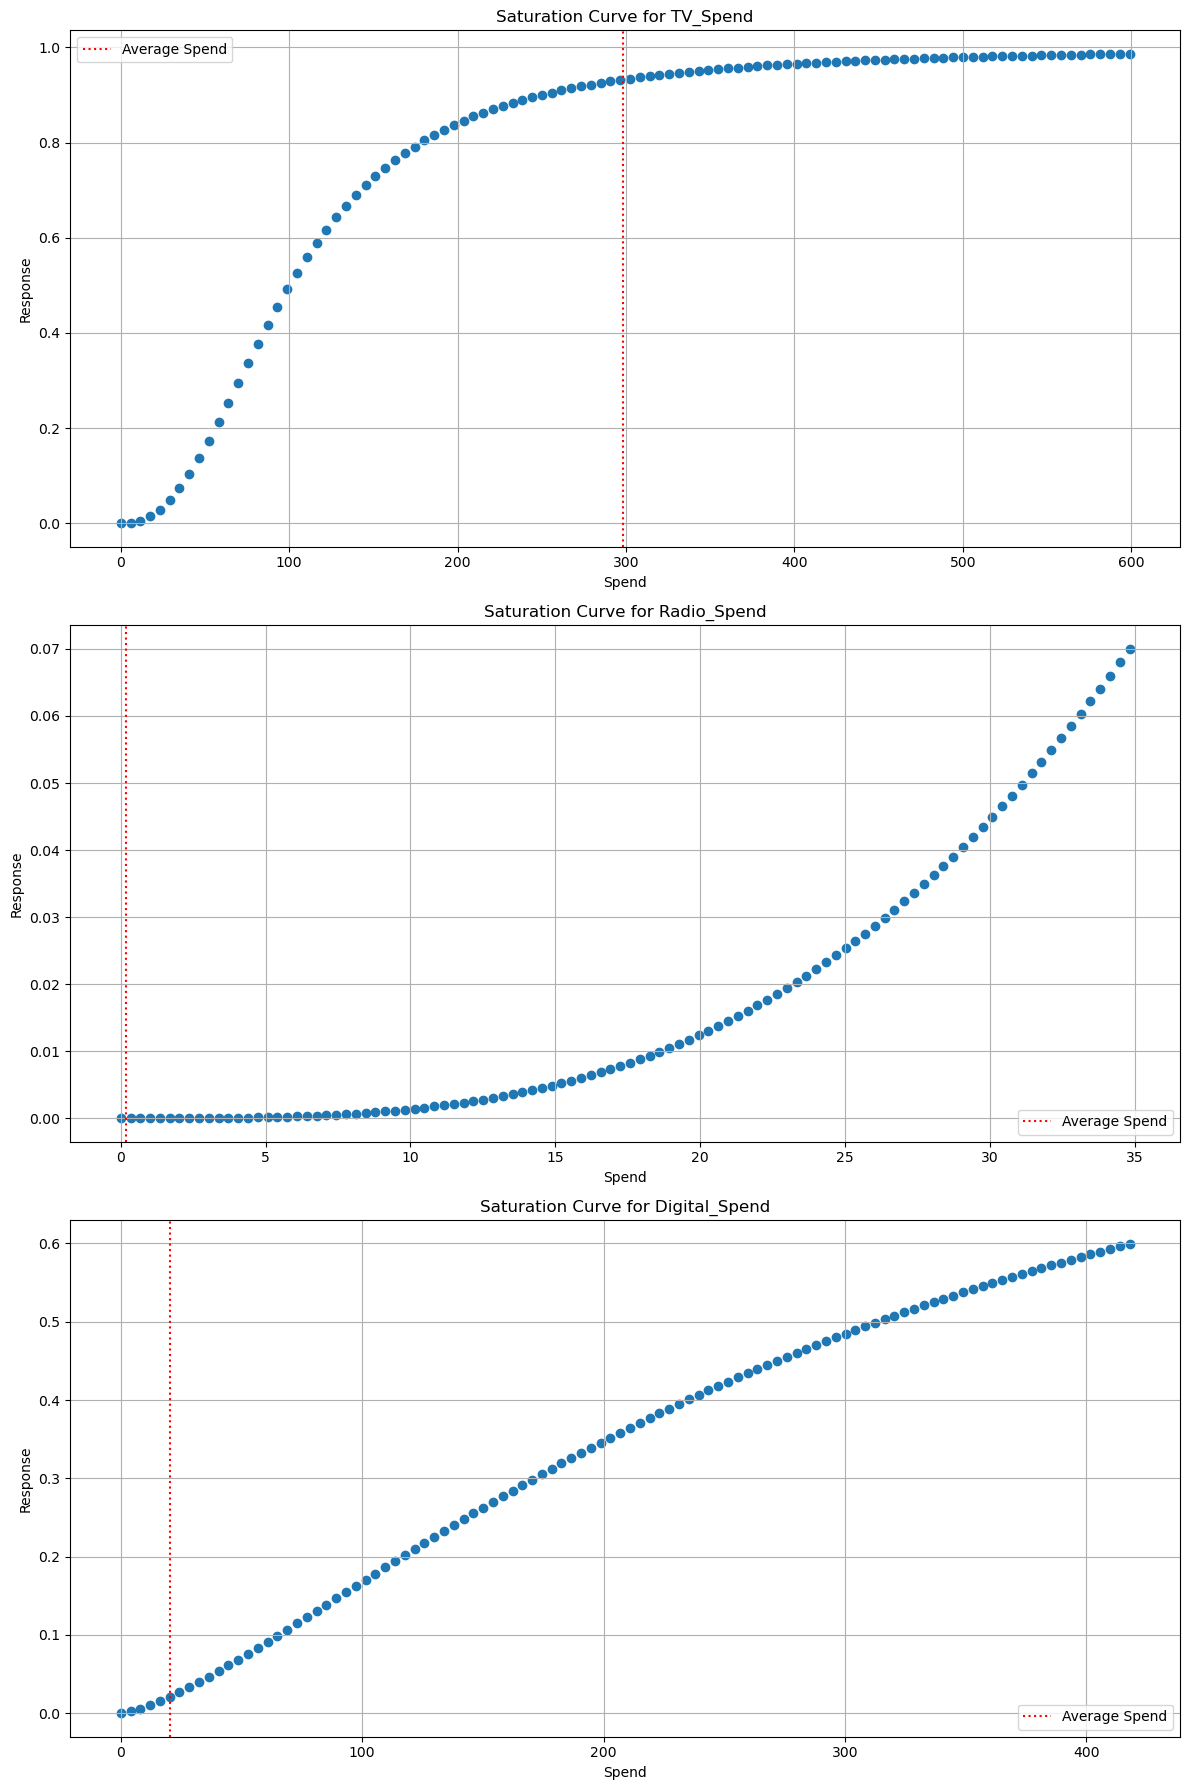

In [20]:
model.plot_saturation_curves()